In [1]:
import numpy as np
from scipy.integrate import odeint
import scipy.interpolate as interp  
import matplotlib.pyplot as plt  
import time   
import  phasediagram as phdt
import  singlependulum as sp  
from scipy.interpolate import griddata 
import scipy.ndimage as ndimage 
import seaborn as sns
import matplotlib
from matplotlib import rc 

In [2]:
 
# ---time step per simulation ------  
# dtU = 0.01
# dt_set= 0.05
dtU = 0.2
dt_set= 0.2
tLast = 7
tU = np.linspace(0,dtU,2) # ---time step per simulation ------   
n_steps = np.int(tLast/dt_set)
print('Number of time steps: '+ str(n_steps) ) 
t_start = time.time()  
 
#-----------child radius----------
rad = dt_set/2.5

#-----------grid size---------- 
y_lim = 10 
# x_steps = 120  + 1 
# y_steps = 240 + 1
x_steps = 60  + 1 
y_steps = 120 + 1

#-----------grid size----------   
x_space = np.linspace(-np.pi,np.pi, x_steps)
y_space = np.linspace(-y_lim,y_lim, y_steps) 
X, Y = np.meshgrid(x_space,y_space) 
 
max_velocity = 10
# ----------physics --------
g = -10
L = 1
mp = 1
Ed = 10 

# ---------controller ------------
R = 100
Q = 1 
u_clip = 3 
n_u = 3  # discretize different control options  
u_opts = np.linspace(-u_clip,u_clip,n_u)


# ---------simulation par  ------------
n_points = 400000  # storage limit   
n_slices = 51    # filter slices 

#----------plotting options ------
intermediate_plotting = False
# intermediate_plotting = True


Number of time steps: 35


In [3]:
def set_ax_lim(ax_fun): 
    
    xlim = np.pi
    ylim = 9
    
    ax_fun.set_xlim([ -xlim,xlim])
    ax_fun.set_ylim([-ylim,ylim])
    return ax_fun 

def compute_U(J_use,x_space,y_space, X,Y, u_opts, tU,Q,R ) :
    U = np.full( np.shape(J_use), np.nan  )
    Eff = np.full( np.shape(J_use), np.nan  )
    t_start = time.time()  

    # spline = interp.interp2d( x_space,y_space,J_use.transpose().ravel() ,kind = 'cubic' )   
    spline = interp.interp2d( x_space,y_space,J_use.transpose().ravel() ,kind = 'linear' )  # works 

    for j in range(len(x_space)):
        for k in range(len(y_space)): 
            yi = np.array( [X[k,j] , Y[k,j]] ) 
            Ji = J_use[k,j ]

            dE_0 =  sp.compute_dE(yi[0],yi[1])
            cost_new_place = np.zeros( np.shape(u_opts) )   

            dE_n = np.zeros( np.shape(u_opts) )   
            for jj, u_c in enumerate(u_opts, start=0):  
                #----------------solve simulation 
                y_n  = odeint(  sp.pendulum_ode, yi,  tU, args=(u_c,)  )[1]    # ode solver 
                y_n[0] = sp.wrap2periodic(y_n[0],2*np.pi, 0 )                  # wrap theta to range of -pi to pi 

                # find cost of the step
                J_n  = sp.calc_costToGo(yi,u_c, Q,R )  * dtU

                # find the effective change of the step
                dE_n[jj] =  sp.compute_dE(y_n[0],y_n[1])

                # compute cost at new step
                cost_new_place[jj] = spline( y_n[0],y_n[1]  )   + J_n

            # compare costs and find which control action is cheapest
            ind_low = np.argmin(cost_new_place)  
            U[k,j] = u_opts[ind_low]  
            Eff[k,j] = dE_n[ind_low] 
    return U 


In [4]:
# #---------------------array of  ICs ----------------------------
n_theta = 200
theta = np.linspace(-np.pi,np.pi, n_theta,endpoint=False)
dTheta = np.sqrt( -2*g - 2*g*np.cos(theta) ) 
one0 = np.ones( (n_theta,3)) 
U0 = np.ones( (n_theta,1)) 

IC0 = np.vstack( (np.column_stack( (theta,dTheta,one0,U0)   ) , 
                np.column_stack( (-theta,-dTheta,one0,U0)   ) )  )   

In [5]:
# initialize point matrix 
point_Mat = np.zeros(( n_points ,6))  
counter = len(IC0)  
point_Mat[:counter] = IC0   

tSave = t_start 
meta_counter = 1
time_sign = -1

for j in range(n_steps):  

    parent_bool = (  point_Mat[:,3]  == 1) &  (point_Mat[:,4]  == 1 )  
    elder_bool = (point_Mat[:,4]  == 1 )  
    subMat = point_Mat[parent_bool,:]  
    
    tNow = time.time()
    delT  = tNow-tSave 
    tSave = tNow 
    print( 'step: ' + str(j) + ', runtime: ' + str( round(tNow-t_start,1) ) + ' sec' + 
          ', dT: ' +  str( round(delT,1) ) + ' sec'  +   ', n_parents: '+str(np.sum(parent_bool ) ) + 
                ', n_elder: '+str(np.sum(elder_bool ))        )    
        
    newest_parent = counter
    for j in range( len(subMat) ):
        Ji = subMat[j,2] 
        yi = subMat[j,[0,1]]
        
        
        dt = dt_set/2+dt_set*np.random.rand(1)[0];  
        t = np.linspace(0,dt,2) # ---time step per simulation ------  
        rad = dt/3
 

        for u_c in u_opts:
            #-------solve ODE --------------------------------------
            yn = odeint(  sp.pendulum_ode, yi,  t, args=(u_c,time_sign,)  ) [1]    # ode solver 
            
            
            dist = np.sqrt( np.sum( (yi-yn)**2 ) )/3
            if dist < rad:
                rad = dist
            
            yn[0] = sp.wrap2periodic( yn[0] )
            Jn = sp.calc_costToGo(yi,u_c, Q,R )*dt + Ji 
            #---------------------------------------------    
            
            dist = np.sqrt(  (point_Mat[:,0] - yn[0] )**2 + (point_Mat[:,1] - yn[1] )**2  ) 
            overlap_bool = dist < rad 
            in_range = np.abs(yn[1]) < max_velocity
            
            # save point if: 
            if (len( point_Mat[overlap_bool,2]) == 0) & in_range:     # empty space found
                point_Mat[counter,:] = np.array([yn[0], yn[1],Jn,1,1,u_c]) 
                counter = counter + 1
            elif np.all( Jn < point_Mat[overlap_bool,2] ) & in_range : # cheapest in the neighborhood 
                point_Mat[counter,:] = np.array([yn[0], yn[1],Jn,1,1,u_c])  
                point_Mat[overlap_bool,4] = 0 # turn off defeated points
                counter = counter + 1  
                
    if intermediate_plotting: 
        f, axs = plt.subplots(1,1,figsize=(10,5) )   
         
        axs.scatter( point_Mat[elder_bool,0], point_Mat[elder_bool,1] ,1 ,'g') 
        axs.scatter( point_Mat[parent_bool,0], point_Mat[parent_bool,1] ,1 ,'r') 
        axs.scatter( point_Mat[newest_parent:counter,0], point_Mat[newest_parent:counter,1] ,1 ,'b') 
        
        set_ax_lim(axs) 
        phd.homoclinic_plot( axs )
        plt.show()
         
    # turn off parent activity for point 
    point_Mat[parent_bool,3] = 0
    
    elder_bool = (point_Mat[:,4]  == 1 )  
    if counter > meta_counter*10000:
        print('Matrix trimming')
        meta_counter = meta_counter +1 
        tempMat = point_Mat[elder_bool,:]
         
        counter = np.shape(tempMat)[0]  
        point_Mat = np.zeros((n_points ,6))
        point_Mat[:counter,:] = tempMat
 
elder_bool = (point_Mat[:,4]  == 1 )    
meta_counter = meta_counter +1
tempMat = point_Mat[elder_bool,:]
 
counter = np.shape(tempMat)[0] 

point_Mat = np.zeros((n_points ,6))
point_Mat[:counter,:] = tempMat
elder_bool = (point_Mat[:,4]  == 1 )    


grid_raw = griddata( point_Mat[elder_bool,:2] ,   point_Mat[elder_bool,2], (X, Y), method='linear') 

J_raw, J_raw_log = sp.matrix_fillnan(grid_raw) 

step: 0, runtime: 0.3 sec, dT: 0.3 sec, n_parents: 400, n_elder: 400
step: 1, runtime: 29.8 sec, dT: 29.5 sec, n_parents: 603, n_elder: 1003
step: 2, runtime: 69.7 sec, dT: 39.9 sec, n_parents: 1022, n_elder: 1927
step: 3, runtime: 139.0 sec, dT: 69.3 sec, n_parents: 1432, n_elder: 3140
step: 4, runtime: 236.7 sec, dT: 97.7 sec, n_parents: 1696, n_elder: 4388
step: 5, runtime: 338.6 sec, dT: 101.8 sec, n_parents: 1899, n_elder: 5740
Matrix trimming
step: 6, runtime: 448.7 sec, dT: 110.1 sec, n_parents: 1997, n_elder: 7074
step: 7, runtime: 572.5 sec, dT: 123.9 sec, n_parents: 2273, n_elder: 8608
step: 8, runtime: 723.7 sec, dT: 151.2 sec, n_parents: 2388, n_elder: 10116
step: 9, runtime: 891.4 sec, dT: 167.7 sec, n_parents: 2236, n_elder: 11412
step: 10, runtime: 1041.4 sec, dT: 150.0 sec, n_parents: 1990, n_elder: 12491
step: 11, runtime: 1183.1 sec, dT: 141.7 sec, n_parents: 1739, n_elder: 13313
Matrix trimming
step: 12, runtime: 1322.7 sec, dT: 139.7 sec, n_parents: 1366, n_elder: 1

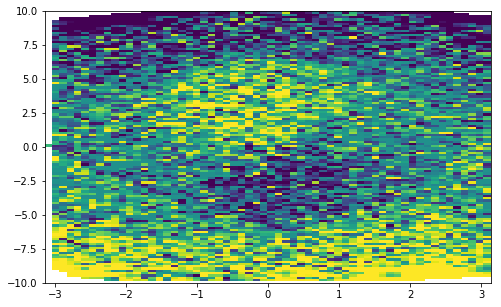

In [6]:

elder_bool = (point_Mat[:,4]  == 1 )    
grid_U = griddata( point_Mat[elder_bool,:2] ,   point_Mat[elder_bool,5], (X, Y), method='linear') 


f, axs = plt.subplots(1,1 ,figsize=(8,5) )    
axs.pcolor(X,Y, grid_U  )   

In [7]:
# yn 


In [8]:
n_slices = 201
intermediate_plotting = False 
angle_range = np.linspace(-np.pi,np.pi,n_slices)

d_angle = angle_range[1]-angle_range[0]
overlap = 1

elder_bool = (point_Mat[:,4]  == 1 )

pos_angle = np.expand_dims( np.arctan2( point_Mat[elder_bool,1] , point_Mat[elder_bool,0]) ,  axis=1)
pos_E = np.expand_dims( sp.compute_dE( point_Mat[elder_bool,0], point_Mat[elder_bool,1] ),  axis=1)
 
data = np.concatenate( ( point_Mat[elder_bool,:] ,pos_E ,pos_angle ) ,axis=1 )
 
keepList = [] 

for j in range(len(angle_range)):    
    
    low_lim = angle_range[j]-(d_angle/2)*(1+overlap)
    high_lim = angle_range[j]+(d_angle/2)*(1+overlap)
    in_range = (pos_angle>low_lim) & (pos_angle<high_lim)
 
    tempData = data[in_range[:,0],:]
    ind_sorted = np.argsort( tempData[:,6])
    tempData2 = tempData[ind_sorted,:] 
    
    minV= np.min(tempData2[:,2])
    minI= np.argmin(tempData2[:,2])
    
    minJList = []
    minJListUp = [] 
    minJList.append(tempData2[0]) 
    minJListUp.append(tempData2[-1]) 
     
    for k in range(len(tempData2)):
        if tempData2[k,2] < minJList[-1][2]:
            minJList.append(tempData2[k,:]) 
            keepList.append(tempData2[k,:]) 
    for k in reversed(range(len(tempData2)) ):
        if tempData2[k,2] < minJListUp[-1][2]:
            minJListUp.append(tempData2[k,:]) 
            keepList.append(tempData2[k,:])  
    minMat = np.asarray(minJList) 
    minMatUp = np.asarray(minJListUp)  
    
    if intermediate_plotting == True: 
        f, axs = plt.subplots(1,1 ,figsize=(8,5) )    
        axs.scatter( tempData2[minI,6],  tempData2[minI,2] ,100, 'r')   
        axs.scatter( tempData2[:,6] , tempData2[:,2] ,1,'g')
        axs.scatter( minMat[:,6] , minMat[:,2] ,1,'b')
        axs.scatter( minMatUp[:,6] , minMatUp[:,2] ,1,'b')

        axs.set_xlim([-20,20]) 
        axs.set_ylim([-50,3000]) 
        axs.set_xlabel('Total energy')
        axs.set_ylabel('Cost J') 
     
point_Mat_filt = np.asarray(keepList)  
 

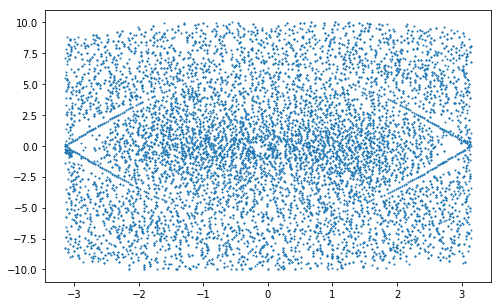

In [9]:
f, axs = plt.subplots(1,1 ,figsize=(8,5) )    
axs.scatter( point_Mat_filt[:,0], point_Mat_filt[:,1] , 1 )

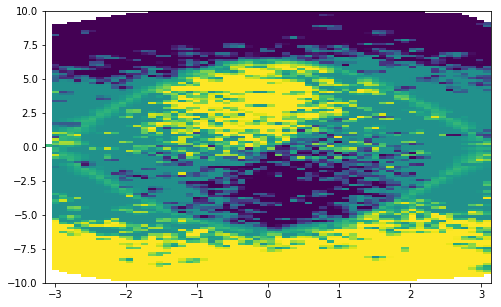

In [10]:

# point_Mat_filt = np.asarray(keepList)  

elder_bool_filt = (point_Mat_filt[:,4]  == 1 )    
grid_U = griddata( point_Mat_filt[elder_bool_filt,:2] ,   point_Mat_filt[elder_bool_filt,5], (X, Y), method='linear') 


f, axs = plt.subplots(1,1 ,figsize=(8,5) )    
axs.pcolor(X,Y, grid_U  )   

In [11]:
filter_on = True 

if filter_on:
    elder_bool = (point_Mat_filt[:,4]  == 1 )
    grid_z1 = griddata( point_Mat_filt[elder_bool,:2] ,   point_Mat_filt[elder_bool,2], (X, Y), method='linear') 
else:
    grid_z1 = grid_raw

J_filter, J_filter_log = sp.matrix_fillnan(grid_z1)   

In [12]:
print('time to run so far: ' + str(round(time.time()-t_start,1)) + ' seconds')

time to run so far: 1936.2 seconds


In [13]:
# combine griddata  
point_Mat_elder = point_Mat_filt 

point_Mat_elder_2 = point_Mat_elder.copy()
point_Mat_elder_2[:,0] = point_Mat_elder[:,0]-2*np.pi  

point_Mat_elder_3 = point_Mat_elder.copy()
point_Mat_elder_3[:,0] = point_Mat_elder[:,0]+2*np.pi  

point_Mat_combined = np.vstack( (point_Mat_elder, point_Mat_elder_2,point_Mat_elder_3)  )
point_Mat_combined[:,7]= np.arctan2( point_Mat_combined[:,1], point_Mat_combined[:,0]  ) 


In [14]:

elder_bool = (point_Mat_combined[:,4]  == 1 )
grid_z1 = griddata( point_Mat_combined[elder_bool,:2] ,   point_Mat_combined[elder_bool,2], (X, Y), method='linear') 

J_combined, J_combined_log = sp.matrix_fillnan(grid_z1)   

In [15]:
# plotting parameters 
max_J = 7
plt.style.use('latex_scientificPaperStyle.mplstyle')
col = sns.color_palette("hls", 5)  
colorsList = [col[2],np.array([255,255,200])/255,col[3]]  
plt.rc('font', family='serif')
rc('text', usetex=True) 
contr = matplotlib.colors.ListedColormap(colorsList) 

# filter and plot reference control map

time to run so far: 1969.4 seconds


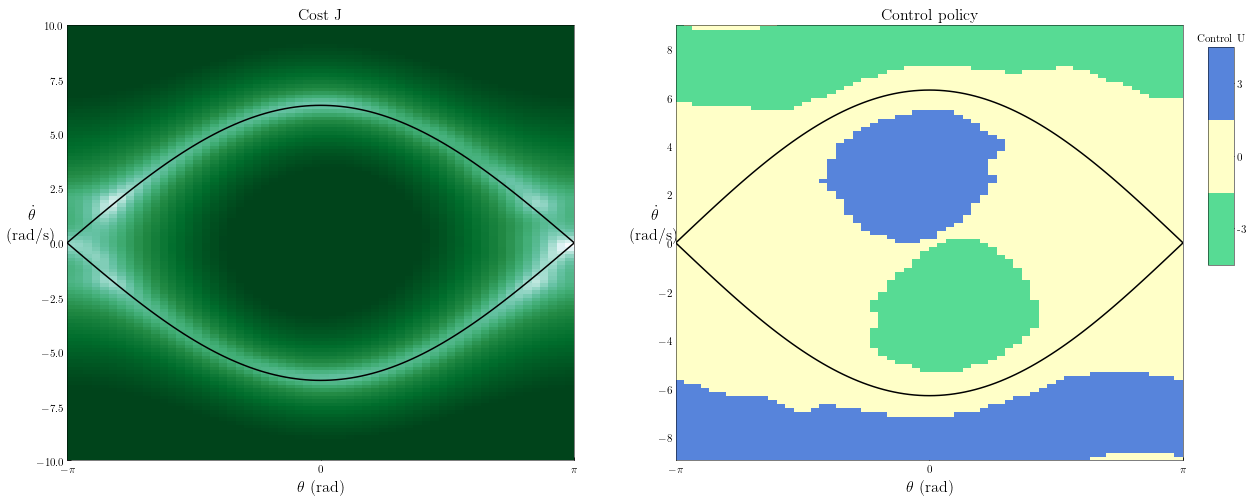

In [16]:
# ----------------------------------- turn filter into J  
Gauss_width = 2   

J_smooth_raw = ndimage.gaussian_filter(J_combined, sigma=Gauss_width, order=0) 
J_smooth, J_smooth_log = sp.matrix_fillnan(J_smooth_raw)  
 
# plot plot radially filtered and gaussian smoothened points
f, axs = plt.subplots(1,2 ,figsize=(20,8) )   
 
axs[0].pcolor(X,Y, J_smooth_log,vmax = max_J , cmap='BuGn' )      
axs[0] = phd.homoclinic_plot(axs[0]) 
     
# figure style 
axs[0].xaxis.set_major_locator(plt.MultipleLocator(np.pi )) 
axs[0].xaxis.set_major_formatter(plt.FuncFormatter(phd.multiple_formatter()))  
# axs[0].set_ylim([-12,12])
set_ax_lim(axs[1])
axs[0].set_xlabel(r' $\theta$ (rad)',fontsize = 16)
axs[0].set_ylabel(r"$\dot{\theta}$"  "\n"  "(rad/s)",fontsize = 16,rotation = 0) 
axs[0].set_title('Cost J',fontsize = 16) 
# axs[0].set_ylim([-12,12])  
  
U_comp = compute_U( J_smooth, x_space, y_space, X,Y, u_opts, tU, Q,R) 
pcol= axs[1].pcolor(X,Y, U_comp , cmap= contr )   

axs[1] = phd.homoclinic_plot(axs[1])
# axs[1].set_ylim([-12,12])
set_ax_lim(axs[1])
axs[1].set_xlabel(r' $\theta$ (rad)',fontsize = 16)
axs[1].set_ylabel(r"$\dot{\theta}$"  "\n"  "(rad/s)",fontsize = 16,rotation = 0) 
axs[1].xaxis.set_major_locator(plt.MultipleLocator(np.pi )) 
axs[1].xaxis.set_major_formatter(plt.FuncFormatter(phd.multiple_formatter()))  
axs[1].set_title('Control policy',fontsize = 16)  

 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
axins = inset_axes(axs[1],
                   width="5%",  # width = 5% of parent_bbox width
                   height="50%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.45, 1, 1),
                   bbox_transform=axs[1].transAxes,
                   borderpad=0,
                   ) 

cbar = f.colorbar(pcol, cax=axins , ticks=[-2,0,2] )
cbar.ax.set_yticklabels([-3,0,3])  # vertically oriented colorbar
cbar.ax.set_title('Control U')  

print('time to run so far: ' + str(round(time.time()-t_start,1)) + ' seconds')  

# Save data

In [ ]:

np.save( 'reference_control_law_lowRes.npy', (U_comp,X,Y) )  